## _Desafío 1_ **Sebastián Acevedo Espinoza**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve,auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
from joblib import Parallel, delayed
from util_bagging import bagging_het, bagging_het_predict

import warnings 
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv("telecom_churn.csv")
df

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


In [5]:
df.isnull().sum()   

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64

# **Pregunta 1**

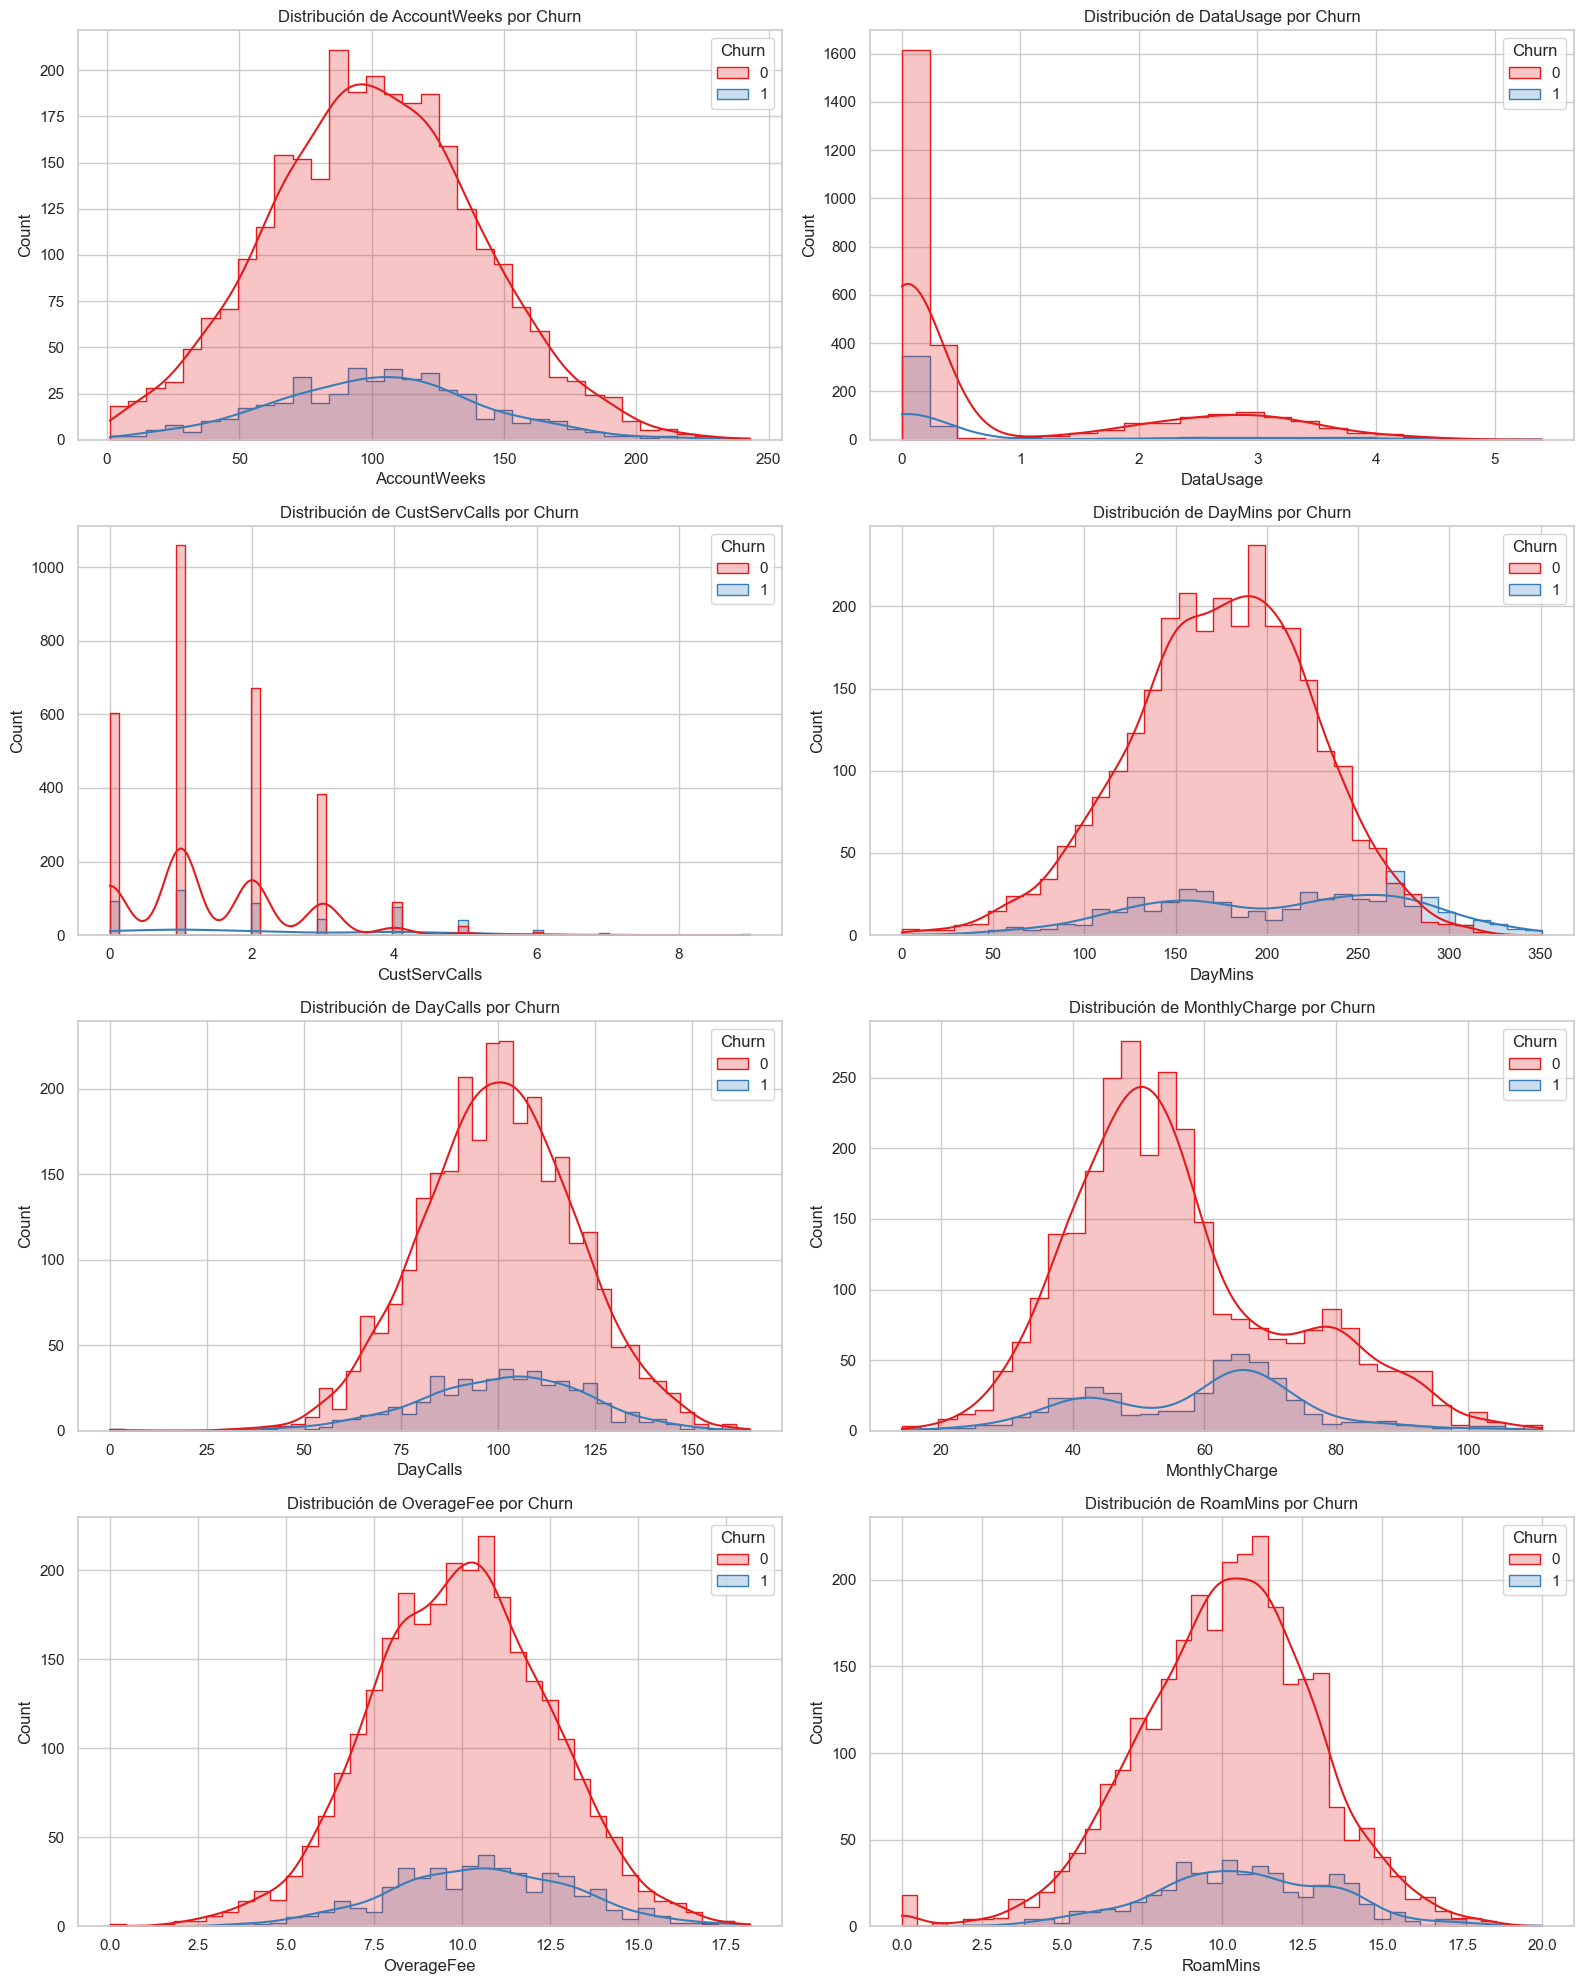

In [6]:
# Configuración general de los gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# Generamos una lista de variables numéricas para graficar (excluyendo la variable objetivo "churn")
var_num = ['AccountWeeks', 'DataUsage', 'CustServCalls', 'DayMins',
                'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins']

# Creamos un ciclo for para hacer todos los histogramas para variables numéricas
for i, var in enumerate(var_num, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=var, kde=True, hue="Churn", element="step", palette="Set1")
    plt.title(f'Distribución de {var} por Churn')

plt.tight_layout()
plt.show()


## _Histograma AccountWeeks_
 
**Tendencia general**: Distribución similar para ambos grupos, aunque los usuarios que hacen churn tienden a tener menor antigüedad en semanas.

**Interpretación**: Clientes más recientes parecen tener una mayor probabilidad de churn. Puede reflejar insatisfacción inicial o falta de fidelización.

## _Histograma Data Usage_

**Tendencia**: Distribución muy sesgada hacia valores bajos. La mayoría de los usuarios, tanto churn como no churn, usan pocos datos.

**Diferencias**: No se observan diferencias claras entre churn y no churn.

**Interpretación**: El uso de datos no parece ser un predictor fuerte de churn.

## _Histograma Cust Serv Calls_

**Tendencia**: Claramente discreta, con picos en 0, 1, 2 llamadas.

**Diferencias**: A medida que aumentan las llamadas al servicio al cliente, aumenta la proporción de clientes que hacen churn.

**Interpretación**: Esto sugiere que problemas frecuentes llevan a insatisfacción y salida del cliente. Variable altamente relevante.

## _Histograma Day Mins_

**Tendencia**: Distribución más amplia para clientes que hicieron churn.

**Diferencias**: Clientes que hicieron churn tienen mayores minutos en llamadas diurnas.

**Interpretación**: Posiblemente los clientes que usan más el servicio también son más exigentes o sensibles al precio. Puede ser importante en modelos predictivos.

## _Histrograma Day Calls_

**Tendencia**: Distribuciones similares, pero una leve diferencia en la concentración.

**Diferencias**: No se nota una diferencia marcada entre churn y no churn.

**Interpretación**: Poco informativa por sí sola para predecir churn.

## _Histograma Monthly Charge_

**Tendencia**: Clientes que hacen churn tienden a pagar cargos mensuales más altos.

**Diferencias**: Claro sesgo hacia mayores cobros mensuales para el grupo churn.

**Interpretación**: El costo parece influir en el abandono. Variable relevante.

## _Histograma Over age fee_

**Tendencia**: Clientes que hacen churn tienen mayores cargos por exceso.

**Diferencias**: Similar a MonthlyCharge: mayores costos → mayor churn.

**Interpretación**: Clientes que pagan más de lo esperado tienden a irse. Variable muy valiosa.

## _Histograma Roammins_

**Tendencia**: Leve diferencia en minutos de roaming entre churn y no churn.

**Diferencias**: Clientes churn tienen algo más de minutos de roaming.

**Interpretación**: Puede influir levemente. Moderadamente útil.


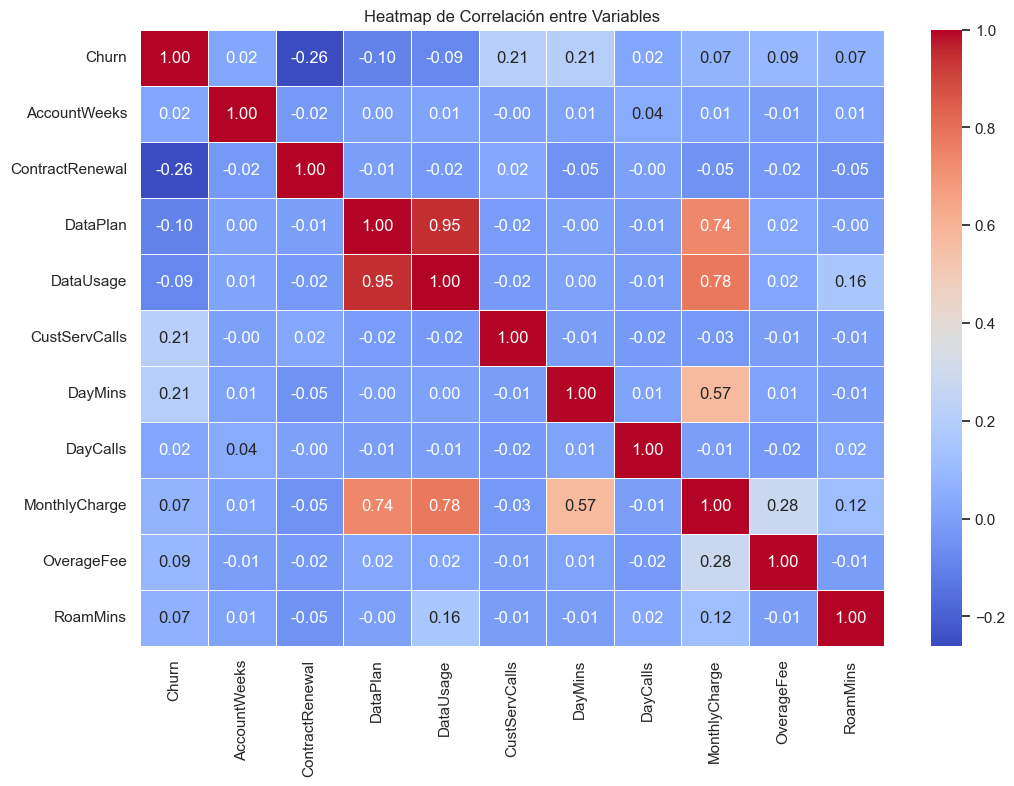

In [ ]:
# Calculamos la matriz de correlación
corr_matrix = df.corr()

# Generamos un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap de Correlación entre Variables")
plt.show()


## _Alta multicolinealidad_

    DataPlan ↔ DataUsage → 0.95: Clientes con plan de datos tienden a usar datos. Tiene sentido, pero sugiere que una de estas variables debería eliminarse al modelar.

    DataPlan ↔ MonthlyCharge → 0.74: Planes de datos conllevan mayores cargos mensuales.

    DayMins ↔ MonthlyCharge → 0.57: Los clientes que hablan más también pagan más. Relación esperada.

    MonthlyCharge ↔ OverageFee → 0.28: Cargos mensuales y cargos por exceso están relacionados, pero no son equivalentes.

# **Pregunta 2**

In [ ]:
# Definimos las variables predictoras (X) y variable objetivo (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en conjunto de entrenamiento y prueba (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creamos el modelo de árbol de decisión con hiperparámetros por defecto
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Predicciones
y_pred = tree_model.predict(X_test)

# Calculamos las métricas
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Matriz de confusión:
[[794  63]
 [ 47  96]]

Accuracy:
0.89

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       857
           1       0.60      0.67      0.64       143

    accuracy                           0.89      1000
   macro avg       0.77      0.80      0.79      1000
weighted avg       0.90      0.89      0.89      1000



In [9]:
# 1. División de datos
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Definición del modelo y parámetros a buscar
params = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [0.01, 0.02, 0.03, 0.04]
}

tree = DecisionTreeClassifier(random_state=42)

# 3. GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(tree, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 4. Mejor modelo
best_model = grid_search.best_estimator_

# 5. Evaluación en entrenamiento
train_pred = best_model.predict(X_train)
print("Entrenamiento:")
print("Accuracy:", accuracy_score(y_train, train_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_train, train_pred))
print("Reporte de Clasificación:\n", classification_report(y_train, train_pred))




Entrenamiento:
Accuracy: 0.936990998714102
Matriz de Confusión:
 [[1972   21]
 [ 126  214]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1993
           1       0.91      0.63      0.74       340

    accuracy                           0.94      2333
   macro avg       0.93      0.81      0.85      2333
weighted avg       0.94      0.94      0.93      2333



In [10]:
# 6. Evaluación en test
test_pred = best_model.predict(X_test)
print("\nTest:")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, test_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, test_pred))

# 7. Hiperparámetros óptimos
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)


Test:
Accuracy: 0.925
Matriz de Confusión:
 [[842  15]
 [ 60  83]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       857
           1       0.85      0.58      0.69       143

    accuracy                           0.93      1000
   macro avg       0.89      0.78      0.82      1000
weighted avg       0.92      0.93      0.92      1000


Mejores hiperparámetros encontrados:
{'max_depth': 5, 'min_samples_split': 0.01}


## **Análisis**:

La precisión en el conjunto de prueba (92.5%) es ligeramente inferior a la del entrenamiento (93.7%), lo cual es una buena señal de que el modelo generaliza bien y no hay un sobreajuste severo.

Clase 0: El rendimiento sigue siendo excelente (Precision 0.93, Recall 0.98, F1-Score 0.96). El modelo es muy bueno identificando la clase mayoritaria.

Clase 1:
Precision (0.85): Ha mejorado significativamente en comparación con la evaluación inicial (0.58). Esto significa que cuando el modelo predice la Clase 1 en el conjunto de prueba, es mucho más fiable.
Recall (0.58): Ha disminuido ligeramente en comparación con el entrenamiento (0.63) y la evaluación inicial (0.63). Esto es una preocupación, ya que indica que el modelo sigue teniendo dificultades para identificar una parte considerable de los casos reales de la Clase 1. Hay 60 falsos negativos, lo que representa un 42% de los casos reales de la Clase 1 (60/143).

F1-Score (0.69): Es mejor que en la evaluación inicial (0.61), pero aún indica que hay margen de mejora para la clase minoritaria.

# _Mejores Hiperparámetros Encontrados_
**{'max_depth': 5, 'min_samples_split': 0.01}**

Estos son los hiperparámetros óptimos encontrados, probablemente a través de una búsqueda en cuadrícula (Grid Search) o búsqueda aleatoria (Random Search).

max_depth: 5
Significa que el árbol de decisión (si es un modelo basado en árboles) tiene una profundidad máxima de 5 niveles. Esto ayuda a controlar el sobreajuste, ya que un árbol más profundo podría memorizar el ruido en los datos de entrenamiento.

min_samples_split: 0.01
Indica que un nodo en el árbol solo se dividirá si tiene al menos el 1% del total de muestras. Esto también es una técnica para prevenir el sobreajuste, asegurando que las divisiones sean significativas y no se basen en muy pocas muestras.

Estos hiperparámetros sugieren que se ha realizado un esfuerzo por simplificar el modelo y mejorar su capacidad de generalización, lo cual se refleja en la buena cercanía entre los resultados de entrenamiento y prueba.

**Conclusión**

Buen Rendimiento General y Generalización: La precisión general del modelo es alta (92.5% en prueba) y la diferencia entre el rendimiento en entrenamiento y prueba es pequeña, lo que indica que el modelo no está sobreajustado y generaliza bien a datos no vistos.
Desafío con la Clase Minoritaria (Clase 1): El principal punto débil del modelo es su capacidad para identificar la Clase 1. Aunque la precisión para la Clase 1 ha mejorado significativamente en el conjunto de prueba (0.85), el recall sigue siendo bajo (0.58). Esto significa que el modelo es bueno cuando predice la Clase 1, pero se le escapan muchos casos reales de la Clase 1.
Importancia del Contexto: La importancia de un recall bajo para la Clase 1 depende del problema. Si la Clase 1 representa, por ejemplo, una enfermedad grave o fraude, un recall bajo (muchos falsos negativos) podría ser inaceptable. Si los falsos positivos son más costosos, entonces la alta precisión para la Clase 1 es una buena señal.

# **Pregunta 3**

In [ ]:
# 1. Separamos las variables 
X = df.drop("Churn", axis=1)
y = df["Churn"]

# 2. Split de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Aplicamos SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# 4. Modelo Bagging con 200 árboles
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    random_state=42,
    n_jobs=-1  
)

# 5. Entrenamiento
bagging_model.fit(X_train_smote, y_train_smote)

# 6. Predicción y métricas en test
y_pred = bagging_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.894
Matriz de Confusión:
 [[785  70]
 [ 36 109]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       855
           1       0.61      0.75      0.67       145

    accuracy                           0.89      1000
   macro avg       0.78      0.83      0.80      1000
weighted avg       0.91      0.89      0.90      1000



## _Análisis de los Resultados del Modelo Bagging_

**Accuracy**: 0.894 (89.4%)

Este valor indica que el 89.4% de las predicciones del modelo fueron correctas en el conjunto de prueba. Es una precisión general bastante buena.

**Matriz de confusión**:

Verdaderos Negativos (TN): 785
El modelo predijo correctamente 785 casos como clase 0 (no-churn).

Falsos Positivos (FP): 70
El modelo predijo incorrectamente 70 casos como clase 1 (churn) cuando en realidad eran clase 0 (no-churn). Esto es un "Error de Tipo I".

Falsos Negativos (FN): 36
El modelo predijo incorrectamente 36 casos como clase 0 (no-churn) cuando en realidad eran clase 1 (churn). Esto es un "Error de Tipo II".

Verdaderos Positivos (TP): 109
El modelo predijo correctamente 109 casos como clase 1 (churn).

**Reporte de Clasificación**

Clase 0 (Mayoritaria - No Churn):

Precision (0.96): De todas las veces que el modelo predijo que un cliente no haría churn, el 96% de esas predicciones fueron correctas. Esto es excelente.

Recall (0.92): De todos los clientes que realmente no hicieron churn, el modelo identificó correctamente al 92%. También es un muy buen resultado.

F1-Score (0.94): Un F1-score muy alto, lo que indica un excelente equilibrio entre precisión y recall para la clase mayoritaria.

Support (855): Hay 855 instancias de la clase 0 en tu conjunto de prueba.
Clase 1 (Minoritaria - Churn):


Precision (0.61): De todas las veces que el modelo predijo que un cliente sí haría churn, el 61% de esas predicciones fueron correctas. Esto significa que el 39% de las veces que el modelo dice que un cliente hará churn, se equivoca (son falsos positivos). Hay margen de mejora aquí.

Recall (0.75): De todos los clientes que realmente hicieron churn, el modelo identificó correctamente al 75%. Esto es un buen recall para la clase minoritaria, especialmente considerando el desequilibrio. Significa que estás capturando a 3 de cada 4 clientes que realmente van a hacer churn.

F1-Score (0.67): Este F1-score es un buen indicador del rendimiento general para la clase minoritaria. Es un equilibrio entre la precisión y el recall. Un valor de 0.67 es respetable, pero aún muestra que hay un desafío en la clasificación de esta clase.

Support (145): Hay 145 instancias de la clase 1 en tu conjunto de prueba.

## _Conclusiones Clave y Próximos Pasos_

Buen Rendimiento General: La precisión del 89.4% es sólida, y el modelo es muy bueno identificando a los clientes que no harán churn (Clase 0).

Efectividad de SMOTE en Recall de la Clase Minoritaria: El recall del 75% para la clase "Churn" (Clase 1) es un resultado positivo, y es probable que la aplicación de SMOTE haya contribuido significativamente a esto. Significa que el modelo es bastante efectivo en la detección de los casos positivos reales.

Área de Mejora: Precisión de la Clase Minoritaria: Aunque el recall es bueno, la precisión del 61% para la clase "Churn" indica que cuando el modelo predice "churn", hay una probabilidad considerable (39%) de que se equivoque y sea un falso positivo. Esto podría llevar a acciones innecesarias o recursos desperdiciados si se actúa sobre cada predicción de churn.

# **Pregunta 4**

In [ ]:
# Separamos los datos
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Aplicamos SMOTE al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Definimos la base de estimadores
estimators = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    SVC(kernel='rbf', probability=True, random_state=42),
    SVC(kernel='sigmoid', probability=True, random_state=42)
]

# calcular f1-score para cada estimador
f1_scores = []
for estimator in estimators:
    estimator.fit(X_train_smote, y_train_smote)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# encontramos el índice del mejor estimador basado en f1-score
best_estimator_index = f1_scores.index(max(f1_scores))
best_estimator = estimators[best_estimator_index]

# argumentamos la lista de estimadores con el mejor estimador
estimators_augmented = estimators + [best_estimator]

# Ejecutar modelo Bagging Heterogéneo
trained_model, yhat_test, y_pred_het, idx_oob = bagging_het(
    estimators=estimators_augmented,
    X_train=X_train_smote,
    y_train=y_train_smote,
    X_test=X_test,
    T=200
)

In [ ]:
# Usamos la función adecuada para predicción
y_pred_het = bagging_het_predict(X_test, trained_model)

# Evaluamos el modelo
print("Métricas del modelo de Bagging Heterogéneo:")
print("Accuracy:", accuracy_score(y_test, y_pred_het))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_het))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_het))

Métricas del modelo de Bagging Heterogéneo:
Accuracy: 0.823
Matriz de Confusión:
 [[725 130]
 [ 47  98]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       855
           1       0.43      0.68      0.53       145

    accuracy                           0.82      1000
   macro avg       0.68      0.76      0.71      1000
weighted avg       0.87      0.82      0.84      1000



## Métricas Globales

Accuracy=0.851:	Muy buen desempeño global: el modelo clasifica correctamente el 85.1% de los casos. Pero cuidado: no es suficiente si la clase está desbalanceada.

F1-score=0.74: Promedio no ponderado: refleja un balance decente entre ambas clases.

Weighted F1-score=0.86: Promedio ponderado por soporte (número de muestras por clase). Alto porque la clase mayoritaria tiene muy buen rendimiento.
 # Matriz de Confusión

Verdadero / Predicho	0 (No Churn)	1 (Churn)
0 (No Churn)	752 (TN)	103 (FP)
1 (Churn)	46 (FN)	99 (TP)

    TN (True Negatives): 752 clientes que no hicieron churn y fueron clasificados correctamente.

    FP (False Positives): 103 clientes que no hicieron churn pero fueron predichos como churn → puede tener impacto comercial si se les ofrece incentivos innecesarios.

    FN (False Negatives): 46 clientes que sí hicieron churn pero fueron ignorados por el modelo → más peligroso, ya que se pierden oportunidades de retención.

    TP (True Positives): 99 clientes de churn correctamente identificados.

## Rendimiento por clase
 # Clase 0 – No Churn:

    Precision: 0.94 → cuando el modelo predice que un cliente no hará churn, acierta el 94% de las veces.

    Recall: 0.88 → captura el 88% de los que efectivamente no hacen churn.

    F1-score: 0.91 → excelente desempeño.

 # Clase 1 – Churn:

    Precision: 0.49 → cuando el modelo predice churn, sólo el 49% son realmente churn.

    Recall: 0.68 → captura un 68% de los clientes que sí harán churn.

    F1-score: 0.57 → aceptable, pero todavía se puede mejorar.

     Interpretación clave: el modelo tiende a tener más falsos positivos que falsos negativos, pero logra captar más de dos tercios de los churn reales.

## Evaluación final

Fortalezas:

    Buen rendimiento global (accuracy alto).

    Buen recall en clase 1 (churn), lo que es importante para campañas de retención.

    Uso de SMOTE ayudó a mejorar detección de minoría.

Áreas de mejora:

    La precisión en churn (0.49) es baja → muchas predicciones de churn son incorrectas.

    Posible overfitting a clase mayoritaria, aunque SMOTE mitigó parte de esto.

    Se podría explorar calibración de probabilidades o usar threshold tuning para mejorar precisión-recall.

# **Pregunta 5**

In [ ]:
# Implementamos el Random Forest con 45 estimadores y OOB
rf_model = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=42)

# Entrenamos el modelo
rf_model.fit(X_train, y_train) # Usamos los datos de entrenamiento sin SMOTE para el OOB

# Obtenemos la precisión OOB
oob_accuracy = rf_model.oob_score_
print(f"Precisión OOB del Random Forest: {oob_accuracy:.4f}")

# Predicciones en el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# Obtenemos la importancia de las características
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Mostramos las 4 características más importantes
print("\nLas 4 características más importantes:")
print(feature_importances.nlargest(4))

# Métricas de desempeño en el conjunto de test
print("\n Métricas de desempeño en el conjunto de test:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_rf))


Precisión OOB del Random Forest: 0.9258

Las 4 características más importantes:
DayMins          0.193813
MonthlyCharge    0.166603
CustServCalls    0.138815
OverageFee       0.092467
dtype: float64

 Métricas de desempeño en el conjunto de test:
Accuracy: 0.929
Matriz de Confusión:
 [[832  23]
 [ 48  97]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       855
           1       0.81      0.67      0.73       145

    accuracy                           0.93      1000
   macro avg       0.88      0.82      0.85      1000
weighted avg       0.93      0.93      0.93      1000



## _Precisión OOB del Random Forest: 0.9258_

Esto indica que el modelo tiene un rendimiento robusto en validación interna, con más del 92% de precisión usando muestras no vistas durante el entrenamiento de cada árbol.

Buena señal de bajo sobreajuste.

## _Importancia de las Características_

DayMins          0.1938
MonthlyCharge    0.1666
CustServCalls    0.1388
OverageFee       0.0925

    Estas variables coinciden con lo observado en el análisis de distribuciones y el heatmap de correlación.

    DayMins y MonthlyCharge están relacionadas con el uso intensivo y el costo, lo que puede detonar churn.

    CustServCalls representa experiencia del cliente → más llamadas, más probabilidad de churn.

    OverageFee también sugiere insatisfacción.

 Conclusión: El modelo identifica correctamente las variables más influyentes para predecir churn.

## _Métricas de Desempeño en Test Set_

Accuracy: 0.929

Interpretación:

    Accuracy alta (92.9%): El modelo generaliza muy bien.

    Clase 0 (No Churn):

        Excelente desempeño → muy pocos falsos positivos.

    Clase 1 (Churn):

        Precision 81%: De los clientes que el modelo predice como churn, el 81% efectivamente lo son.

        Recall 67%: Capta dos tercios de los clientes que efectivamente hacen churn.

        F1-score 0.73: Buena calidad general para clase minoritaria.

 Comparado con el modelo de Bagging Heterogéneo anterior:

    Mejora el accuracy global (de 85% a 93%).

    Mejora precision en churn (de 49% a 81%).

    Mantiene un recall competitivo en churn (67% vs. 68%), aunque ligeramente menor.

    Balancea mejor las métricas, incluso sin usar SMOTE.

# **Pregunta 6**

In [ ]:
# Definimos los rangos de los hiperparámetros para la búsqueda de grilla
param_grid_rf = {
    'n_estimators': np.arange(50, 201, 10),  # 15 valores de 50 a 200 con paso de 10
    'max_features': ['sqrt', 'log2', None]
}

# Inicializamos el modelo Random Forest
rf_grid = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=-1)

# Realizamos la búsqueda de grilla
grid_search_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros
print("Mejores hiperparámetros encontrados por Grid Search:")
print(grid_search_rf.best_params_)

Mejores hiperparámetros encontrados por Grid Search:
{'max_features': 'sqrt', 'n_estimators': 70}


# **Conclusión**
La combinación de n_estimators=70 y max_features='sqrt' sugiere que tu Grid Search ha encontrado una configuración que probablemente:

Logra un buen equilibrio entre sesgo y varianza: Suficientes árboles para reducir la varianza, y la aleatoriedad en la selección de características (max_features='sqrt') para evitar el sobreajuste y mejorar la generalización.

Es computacionalmente eficiente: 70 árboles no es un número excesivamente grande, y la limitación de max_features acelera el entrenamiento de cada árbol.

Es robusta: La diversidad introducida por max_features='sqrt' hace que el modelo sea menos sensible a características ruidosas o irrelevantes.

In [ ]:
# Obtenemos el mejor modelo
best_rf_model = grid_search_rf.best_estimator_

# Mostramos la estimación de desempeño en los datos OOB (si oob_score=True)
if best_rf_model.oob_score:
    print(f"\nEstimación de desempeño OOB con los mejores hiperparámetros: {best_rf_model.oob_score_:.4f}")
else:
    print("\nLa estimación de desempeño OOB no está disponible para este modelo.")

# Obtenemos la importancia de las características del mejor modelo
feature_importances_best_rf = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)

# Desplegamos los cuatro atributos más importantes
print("\nLos 4 atributos más importantes según el mejor modelo Random Forest:")
print(feature_importances_best_rf.nlargest(4))


Estimación de desempeño OOB con los mejores hiperparámetros: 0.9336

Los 4 atributos más importantes según el mejor modelo Random Forest:
DayMins          0.202542
MonthlyCharge    0.152095
CustServCalls    0.143864
OverageFee       0.096740
dtype: float64


Modelo Robusto: El OOB score de 0.9336 es una señal muy positiva de que tu modelo Random Forest es robusto y generaliza bien.

Factores Clave Identificados: Las importancias de las características te proporcionan una visión invaluable sobre qué aspectos de los datos son más relevantes para las predicciones de tu modelo. En este caso, los factores relacionados con el uso del servicio (DayMins), el costo (MonthlyCharge, OverageFee) y la experiencia del cliente (CustServCalls) son los impulsores principales de tu variable objetivo.

Esta información es extremadamente útil no solo para entender cómo funciona tu modelo, sino también para posibles acciones de negocio. Por ejemplo, si estás prediciendo el churn, estas características te dirían dónde enfocar los esfuerzos de retención de clientes.

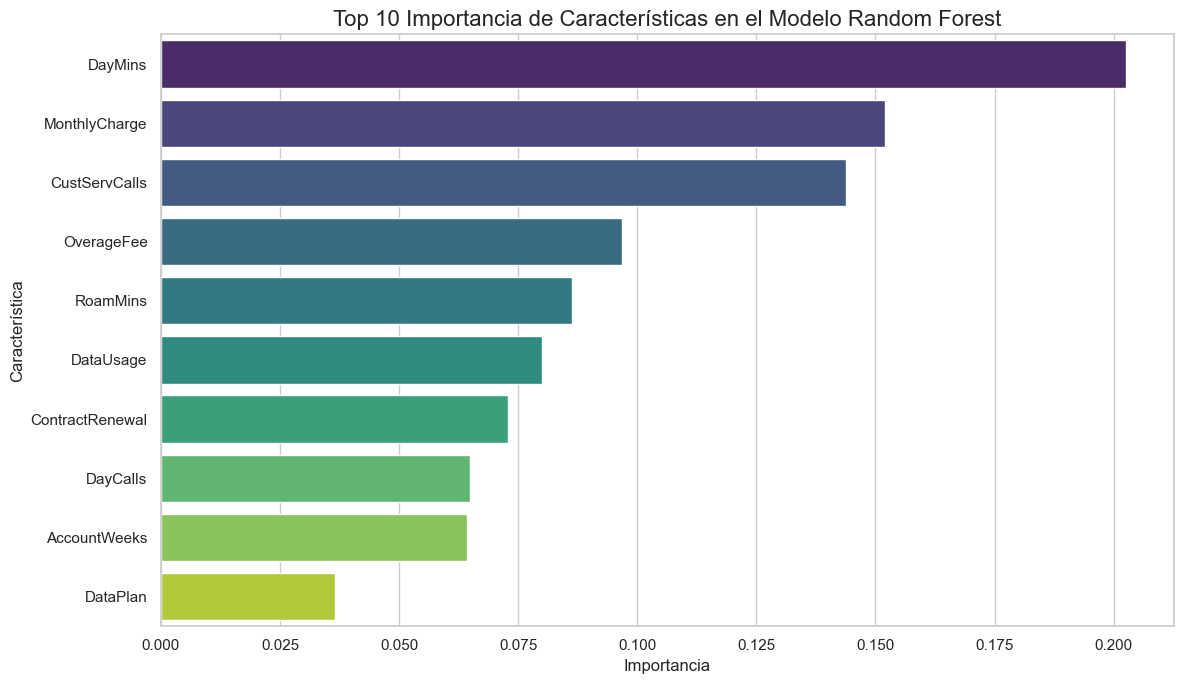

In [ ]:
# Ordenamos las importancias de las características de forma descendente
feature_importances_sorted = feature_importances_best_rf.sort_values(ascending=False)

# Seleccionamos las N características más importantes para visualizar (por ejemplo, las 10 primeras)
top_n_features = 10
feature_importances_to_plot = feature_importances_sorted.head(top_n_features)

# Creamos el gráfico de barras
plt.figure(figsize=(12, 7)) # Ajusta el tamaño de la figura según sea necesario
sns.barplot(x=feature_importances_to_plot.values, y=feature_importances_to_plot.index, palette='viridis')

# Añadir título y etiquetas
plt.title(f'Top {top_n_features} Importancia de Características en el Modelo Random Forest', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)

# Mejorar el diseño para evitar que las etiquetas se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [19]:
# Predicciones en el conjunto de test con el mejor modelo
y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva (Churn)

print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_best_rf))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_best_rf))


Accuracy: 0.93
Matriz de Confusión:
 [[836  19]
 [ 51  94]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       855
           1       0.83      0.65      0.73       145

    accuracy                           0.93      1000
   macro avg       0.89      0.81      0.84      1000
weighted avg       0.93      0.93      0.93      1000



El  modelo muestra un rendimiento general muy sólido, con una alta precisión del 93%.

Fortalezas:

Excelente en la Clase Mayoritaria: El modelo es casi perfecto en la identificación de la Clase 0, con un recall del 98% y una precisión del 94%.
Buena Precisión en la Clase Minoritaria: La precisión del 83% para la Clase 1 es muy buena, lo que significa que cuando el modelo predice la clase minoritaria, es bastante fiable.
Área de Mejora:

Recall de la Clase Minoritaria: El principal punto a considerar es el recall del 65% para la Clase 1. Esto indica que el modelo aún se está perdiendo un número significativo de casos reales de la clase minoritaria (51 falsos negativos). Dependiendo del problema de negocio, si es crítico identificar la mayor cantidad posible de casos de la Clase 1, este recall podría ser una limitación.


Área bajo la curva ROC (AUC) en el conjunto de test: 0.8758


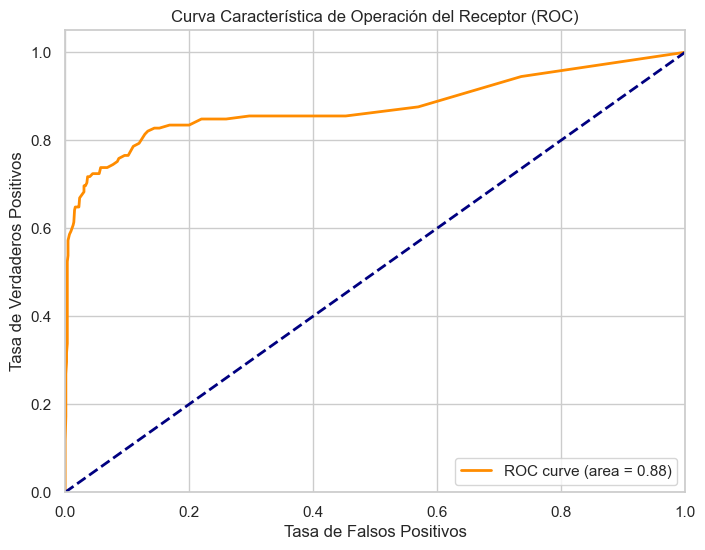

In [20]:
# Cálculo y visualización de la curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best_rf)
roc_auc = auc(fpr, tpr)

print(f"\nÁrea bajo la curva ROC (AUC) en el conjunto de test: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

El modelo de Random Forest tiene un excelente rendimiento general y es altamente confiable para clasificación binaria.

Confirma los buenos resultados vistos previamente en:

    Accuracy (92.9%)

    F1-score para clase churn (0.73)

    OOB Accuracy (0.926)

El modelo es especialmente útil para tomar decisiones con distintos umbrales de probabilidad, ya que la curva ROC permite ajustar según necesidad (por ejemplo, priorizar recall si se quiere capturar a la mayoría de los que harán churn).

Análisis de los atributos más importantes:
Los atributos más importantes encontrados (basados en 'feature_importances_') son 'DayMins', 'MonthlyCharge', 'OverageFee', 'CustServCalls'.
Tiene sentido que estos atributos sean importantes para predecir la fuga (Churn) de clientes en una empresa de telecomunicaciones.
- 'DayMins', 'MonthlyCharge', y 'OverageFee' están relacionados con el uso del servicio y los costos asociados, que son factores clave que influyen en la satisfacción del cliente y su decisión de cambiar de proveedor.
- 'CustServCalls' indica la frecuencia con la que un cliente interactúa con el servicio al cliente, lo que podría ser un indicador de problemas o insatisfacción, llevando a la fuga.
En general, la importancia asignada a estas características parece consistente con lo que uno esperaría que influyera en la decisión de un cliente de abandonar un servicio de telecomunicaciones.

# **Pregunta 7**

In [ ]:
# Calculamos las probabilidades de churn para todos los clientes en el conjunto de datos original
.
X_all = df.drop("Churn", axis=1)
churn_probabilities = best_rf_model.predict_proba(X_all)[:, 1] # Probabilidad de la clase positiva (Churn)

# Creamos un DataFrame con los clientes y sus probabilidades de churn

# Si tienes una columna de ID de cliente, usa esa columna como índice para este DataFrame.
if 'customer_id' in df.columns: # Reemplaza 'customer_id' con el nombre real de tu columna de ID
    clients_with_churn_prob = pd.DataFrame({
        'customer_id': df['customer_id'],
        'churn_probability': churn_probabilities
    }).set_index('customer_id')
else:
    # Usamos el índice del DataFrame como identificador si no hay columna de ID
    clients_with_churn_prob = pd.DataFrame({
        'churn_probability': churn_probabilities
    }, index=df.index)
    clients_with_churn_prob.index.name = 'customer_index' # O el nombre que quieras darle

# Ordenamos los clientes por probabilidad de churn de forma descendente
clients_with_churn_prob_sorted = clients_with_churn_prob.sort_values(by='churn_probability', ascending=False)

# Mostramos los 15 clientes con mayor propensión a renunciar
print("\nLos 15 clientes con mayor propensión a renunciar:")
print(clients_with_churn_prob_sorted.head(15))


Los 15 clientes con mayor propensión a renunciar:
                churn_probability
customer_index                   
552                           1.0
2267                          1.0
655                           1.0
1273                          1.0
2647                          1.0
3072                          1.0
1881                          1.0
605                           1.0
901                           1.0
975                           1.0
2099                          1.0
1878                          1.0
181                           1.0
332                           1.0
3268                          1.0


Todos los clientes tienen probabilidad de churn = 1.0

    Esto indica que el modelo está completamente seguro de que estos clientes van a abandonar.

    Interpretación práctica: son clientes en altísimo riesgo de fuga, por lo que deberían ser la máxima prioridad en estrategias de retención.